# MCMC 2.1: application for parameter estimation

In this notebook, we will use a Markov Chain based on the Metropolis-Hastings algorithm to estimate neutrino oscillation parameters.

The experiment setup simulated in this notebook is the one of the Deep Underground Neutrino Experiment (DUNE). DUNE measures neutrino oscillations by observing the transition of a muon (anti)neutrino beam created in Fermilab toward electron and tau (antineutrinos) in the far detector located 1'300 km away, in the Sanford Underground Research Facility. 

In [1]:
### Import necessary python packages

# math package
import numpy as np

# plotting packages
import matplotlib as mpl
from matplotlib import pyplot as plt

# input files reading package 
import json

# data container package
import pandas as pd

# get the time
from datetime import datetime

import corner
import emcee

In [2]:
def print_progress_bar(iteration, total, prefix='', suffix='', decimals=1, length=50, fill='█'):
    """
    Affiche une barre de progression dans la console.
    
    :param iteration: Itération actuelle (int)
    :param total: Total des itérations (int)
    :param prefix: Préfixe de la barre (str)
    :param suffix: Suffixe de la barre (str)
    :param decimals: Nombre de décimales dans le pourcentage (int)
    :param length: Longueur de la barre de progression (int)
    :param fill: Caractère de remplissage de la barre (str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = fill * filled_length + '-' * (length - filled_length)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end='\r')
    # Print New Line on Complete
    if iteration == total:
        print()

In [3]:
### Setup plot options

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"


## 1. Obtain the neutrino flux

The input is the charged-current event rate of neutrino interactions in the DUNE far detector. The event rate has been obtained from the ancillary files published at: https://arxiv.org/abs/2103.04797

In [4]:
### Function to read a JSON with several dictionaries separated by a new line

def json_reader(filename):
    with open(filename) as f:
        for line in f:
            yield json.loads(line)


In [5]:
### Read JSON file

flux_file = "dune_flux_hist.json"

flux_data = list(json_reader(flux_file))
len(flux_data), flux_data[0].keys()

(144,
 dict_keys(['file', 'config', 'nu', 'flux', 'osc', 'bins', 'counts', 'xaxis_title', 'yaxis_title']))

### 1.1 Unoscillated event rate

The input is the charged-current event rate of neutrino interactions in the DUNE far detector. The event rate has been obtained from the ancillary files published at: https://arxiv.org/abs/2103.04797

In [6]:
### Select dictionary for FD, neutrino mode, muon neutrino unoscillated event rate

config = 'flux_dune_neutrino_FD'
nu_type = 'numu'
flux_type = 'cceventrate'
osc = ''

flux_data_numode_fd = [f for f in flux_data if f['config'] == config]
flux_data_numode_fd_numu = [f for f in flux_data_numode_fd if f['nu'] == nu_type]
flux_data_numode_fd_numu_ccrate = [f for f in flux_data_numode_fd_numu if f['flux'] == flux_type]
flux_data_numode_fd_numu_ccrate_unosc = [f for f in flux_data_numode_fd_numu_ccrate if f['osc'] == osc]

evt_rate_unosc = flux_data_numode_fd_numu_ccrate_unosc[0]
evt_rate_unosc.keys()

dict_keys(['file', 'config', 'nu', 'flux', 'osc', 'bins', 'counts', 'xaxis_title', 'yaxis_title'])

In [7]:
### Select dictionary for FD, neutrino mode, muon neutrino oscillated event rate

config = 'flux_dune_neutrino_FD'
nu_type = 'numu'
flux_type = 'cceventrate'
osc = 'osc'

flux_data_numode_fd = [f for f in flux_data if f['config'] == config]
flux_data_numode_fd_numu = [f for f in flux_data_numode_fd if f['nu'] == nu_type]
flux_data_numode_fd_numu_ccrate = [f for f in flux_data_numode_fd_numu if f['flux'] == flux_type]
flux_data_numode_fd_numu_ccrate_osc = [f for f in flux_data_numode_fd_numu_ccrate if f['osc'] == osc]

evt_rate_osc = flux_data_numode_fd_numu_ccrate_osc[0]
evt_rate_osc.keys()

dict_keys(['file', 'config', 'nu', 'flux', 'osc', 'bins', 'counts', 'xaxis_title', 'yaxis_title'])

### 1.2 Oscillated event rate

We will use as model the simplified case of 2 neutrino flavours, the neutrino oscillation "appearance" probability is: 
$$ P_{\nu_{\mu} \rightarrow \nu_e} \ = \ \sin^2 (2\theta) \ \sin^2 \left( \frac{\Delta m^2 L}{4E} \right) $$
with: 
$$ \sin^2 \left( \frac{\Delta m^2 L}{4E} \right) \ \simeq \ \sin^2 \left( 1.27 \frac{\Delta m^2 [eV^2] \ L[km]}{E[GeV]} \right) $$
so the "disappearance" probability is: 
$$ P_{\nu_{\mu} \rightarrow \nu_{\mu}} \ = 1 - P_{\nu_{\mu} \rightarrow \nu_e} $$

The oscillation parameters are the mixing angle $\theta$ and the square of mass difference $\Delta m^2$. We want to estimate them using the histograms that we extracted.

In [8]:
### Define the oscillation probability

def osc_proba(E, theta=np.pi/4, Dm2=2.2e-3, L=1300):
    sin1 = np.sin(2*theta)**2
    sin2 = np.sin(1.27 * Dm2 * L / E)**2
    return 1 - sin1 * sin2

In [9]:
### Function to apply the oscillation to the unoscillated histogram 

def compute_osc_histo(theta, Dm2, hist): 

    # we will take the energy at the bin center
    bin_centers = []
    evt_rate_osc = [0]

    # loop over bins
    for i_b in np.arange(1, len(hist['bins'])):
        bin_centers.append(hist['bins'][i_b] - ((hist['bins'][i_b] - hist['bins'][i_b-1])/2))
        evt_rate_osc.append(hist['counts'][i_b] * osc_proba(bin_centers[-1], theta, Dm2))
    
    return evt_rate_osc

In [10]:
### Apply the oscillation to the unoscillated histogram and plot at the result

theta_true = np.pi/4
Dm2_true = 2.2e-3

evt_rate_osc_true = compute_osc_histo(theta_true, Dm2_true, evt_rate_unosc)


### 1.3 Compare the event rates

We will now compare the unoscillated and oscillated event rate. 

<>:23: SyntaxWarning: invalid escape sequence '\ '
<>:24: SyntaxWarning: invalid escape sequence '\ '
<>:23: SyntaxWarning: invalid escape sequence '\ '
<>:24: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_11480/2468853505.py:23: SyntaxWarning: invalid escape sequence '\ '
  ax.set_xlabel(r'$' + evt_rate_unosc['xaxis_title'].replace('#', '\\').replace(' ', ' \ ') +'$', fontsize=12)
/tmp/ipykernel_11480/2468853505.py:24: SyntaxWarning: invalid escape sequence '\ '
  ax.set_ylabel(r'$' + evt_rate_unosc['yaxis_title'].replace('#', '\\').replace(' ', ' \ ') +'$', fontsize=12)


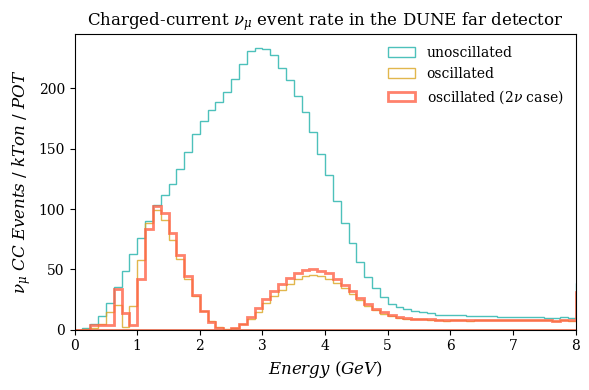

In [11]:
### Plot the fluxes

fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(6,4), tight_layout=True)

# unoscillated rate from the DUNE ancillary file
ax.hist(evt_rate_unosc['bins'][:-1], bins=evt_rate_unosc['bins'], weights=[rate * 20 * 1.47e21 for rate in evt_rate_unosc['counts'][:-1]],
        color=None, edgecolor='lightseagreen', fill=False, lw=1, ls = '-', 
        histtype= "stepfilled", alpha= 0.8, label= 'unoscillated')

# oscillated rate from the DUNE ancillary file
ax.hist(evt_rate_osc['bins'][:-1], bins=evt_rate_osc['bins'], weights=[rate * 20 * 1.47e21 for rate in evt_rate_osc['counts'][:-1]],
        color=None, edgecolor='goldenrod', fill=False, lw=1, ls = '-', 
        histtype= "stepfilled", alpha= 0.8, label= 'oscillated')

# oscillated rate computed with the 2-neutrino formula
ax.hist(evt_rate_unosc['bins'], bins=evt_rate_unosc['bins'], weights=[rate * 20 * 1.47e21 for rate in evt_rate_osc_true],
        color=None, edgecolor='tomato', fill=False, lw=2, ls = '-', 
        histtype= "stepfilled", alpha= 0.8, label= r'oscillated (2$\nu$ case)')

# title and axes
ax.set_title(r'Charged-current $\nu_{\mu}$ event rate in the DUNE far detector')
ax.set_xlim([0, 8])
ax.set_xlabel(r'$' + evt_rate_unosc['xaxis_title'].replace('#', '\\').replace(' ', ' \ ') +'$', fontsize=12)
ax.set_ylabel(r'$' + evt_rate_unosc['yaxis_title'].replace('#', '\\').replace(' ', ' \ ') +'$', fontsize=12)
ax.legend(frameon=False)


## 2. Set up the Markov Chain

We will use a Markov Chain to sample the posterior probability of the $\theta$ and $\Delta m^2$ parameters. The MCMC process at each step is: 
- throw a value of $\theta$ and $\Delta m^2$: $\{\theta_i, \Delta m^2_i \}$
- compute the oscillation probability for those parameter value at the DUNE energy $E_j$: $P_{\nu_{\mu} \rightarrow \nu_e}(\theta_i, \Delta m^2_i, E_j)$
- apply the oscillation probability to the unoscillated histogram: $ N_{osc(i)}(E_j) =  N_{unosc}(E_j) \times P_{\nu_{\mu} \rightarrow \nu_e}(\theta_i, \Delta m^2_i, E_j ) $
- compute the likelihood between the generated oscillated histogram and the one extracted from the file: 
- compute the Metropolis-Hastings ratio $r_i$ between the likelihood at this step and the likelihood at the previous step
- apply the acceptance function $A_i$
- redo until reaching the desired number of steps

### 2.1 Define the target distribution

The target distribution is the posterior probability of the $\theta$ and $\Delta m^2$ parameters. The MCMC will sample:  
$$ P(\theta, \Delta m^2 | \vec{D}) = P(\vec{D} | \theta, \Delta m^2) \ P(\theta, \Delta m^2) $$
where 
- $ P(\theta, \Delta m^2 | \vec{D}) $ is the posterior probability 
- $ P(\vec{D} | \theta, \Delta m^2) $ is the likelihood 
- $P(\theta, \Delta m^2)$ is the prior probability on the parameters $\theta$ and  $\Delta m^2$ 

**2.1.1 Prior probability**

We use a uniform prior probability on $\theta$ and $\Delta m^2$: 
$$ P(\theta) = \sqcap(-\pi/2, \pi/2) $$
$$ P(\Delta m^2) = \sqcap(0, 0.01) $$

defined as: 
- $P(\theta) = 1$ if $\theta \in [-\pi/2, \pi/2]$
- $P(\Delta m^2) = 1$ if $\Delta m^2 \in [0, 10^{-2}]$
- $P(\theta, \Delta m^2) = 0$ elsewehere


In [55]:
def likelihood(list):
    Likelihood=0
    for i in range(len(list)):
       if list[i] != 0 and evt_rate_osc_true[i] != 0:
            Likelihood += list[i] - evt_rate_osc_true[i] + evt_rate_osc_true[i]*np.log(evt_rate_osc_true[i]/list[i])
    return Likelihood*20*1.47e21

In [56]:
def osc_proba(E, theta=np.pi/4, Dm2=2.2e-3, L=1300):
    sin1 = np.sin(2 * theta)**2
    sin2 = np.sin(1.27 * Dm2 * L / E)**2
    return 1 - sin1 * sin2


In [57]:
def compute_osc_histo(theta, Dm2, hist):
    bin_centers = []
    evt_rate_osc = []

    for i_b in np.arange(1, len(hist['bins'])):
        center = hist['bins'][i_b] - ((hist['bins'][i_b] - hist['bins'][i_b-1]) / 2)
        bin_centers.append(center)
        evt_rate_osc.append(hist['counts'][i_b] * osc_proba(center, theta, Dm2))
    
    return evt_rate_osc


In [58]:
def likelihood(list, evt_rate_osc_true):
    Likelihood = 0
    for i in range(len(list)):
        if list[i] != 0 and evt_rate_osc_true[i] != 0:
            Likelihood += list[i] - evt_rate_osc_true[i] + evt_rate_osc_true[i] * np.log(evt_rate_osc_true[i] / list[i])
    return Likelihood * 20 * 1.47e21


In [59]:
def log_likelihood(theta, hist, Dm2):
    model_counts = compute_osc_histo(theta, Dm2, hist)
    obs_counts = hist['counts']  # Ignorer le premier bin si nécessaire
    model_counts = np.array(model_counts)  # S'assurer que c'est un tableau NumPy

    return -likelihood(obs_counts, model_counts)


In [60]:
def log_prior(theta):
    if 0 < theta < np.pi/2 and 0 < Dm2 < 0.01:
        return 0.0
    return -np.inf

def log_posterior(theta, hist, Dm2):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, hist, Dm2)


In [97]:
import emcee
import numpy as np
%time
# Exemple de données histogrammées
hist = {
    'bins': list(range(137)),  # Exemples de bords de bins
    'counts': [evt_rate_osc['counts'][i] for i in range(len(evt_rate_osc['counts']))]  # Comptes observés dans chaque bin
}
Dm2 = 2.2e-3  # Exemple de valeur pour Dm2

# Initialisation des walkers
nwalkers = 15
ndim = 1  # Seulement theta à ajuster
initial = np.array([np.pi/6])  # Exemple de valeur initiale pour theta
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)

# Exécuter MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(hist, Dm2))
sampler.run_mcmc(pos, 15000)

# Analyse des résultats
samples = sampler.get_chain(discard=100, thin=15, flat=True)
%time


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.29 µs


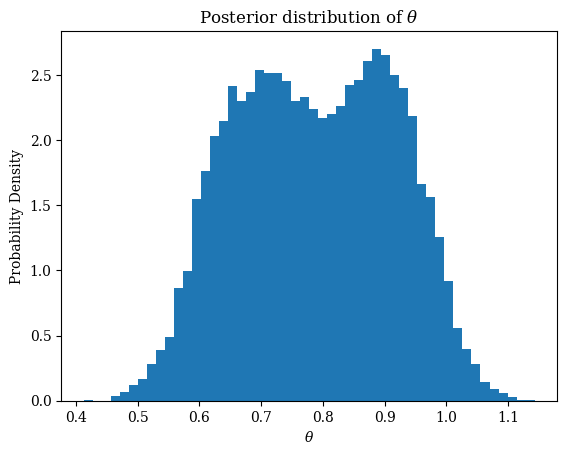

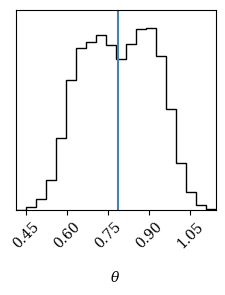

ValueError: x and y must have same first dimension, but have shapes (136,) and (137,)

<Figure size 640x480 with 0 Axes>

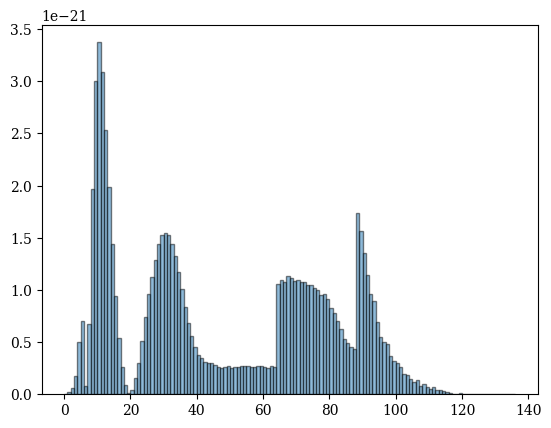

In [98]:
plt.figure()
plt.hist(samples, bins=50, density=True)
plt.xlabel(r'$\theta$')
plt.ylabel('Probability Density')
plt.title(r'Posterior distribution of $\theta$')
plt.savefig('distrib_tet.png')
plt.show()

# 3. Tracé en coin des distributions postérieures
corner.corner(samples, labels=[r'$\theta$'], truths=[np.pi/4])
plt.show()

# 4. Comparaison du modèle ajusté aux données observées

# Calculer le modèle ajusté avec les paramètres moyens
theta_median = np.median(samples, axis=0)
model_counts = compute_osc_histo(theta_median[0], Dm2, hist)

plt.figure()

plt.figure()
plt.hist(hist['bins'][:-1], bins=hist['bins'], weights=hist['counts'][:-1], edgecolor='k', alpha=0.5, label='Observed Data')
plt.step(hist['bins'][:-1], [0] + model_counts, where='mid', color='r', label='Best Fit Model')
plt.xlabel('Energy (E)')
plt.ylabel('Event Rate')
plt.legend()
plt.title('Observed Data vs. Best Fit Model')
plt.show()





In [99]:
np.median(samples, axis=0)

array([0.78841279])

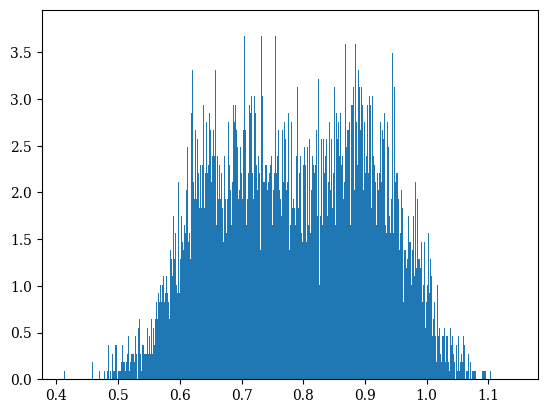

In [100]:
Nested = plt.hist(samples, bins=1000, density=True)

In [101]:
np.max(Nested[0])

3.7678160321953844

In [103]:
print(f"Le nombre de coup max pour la valeur de θ est {np.max(Nested[0])}")



for i in range(len(Nested[0])):
   if Nested[0][i] == np.max(Nested[0]) :
        print(i)
print('Elle vaut θ = ' + str(Nested[1][451]))


Le nombre de coup max pour la valeur de θ est 3.7678160321953844
451
Elle vaut θ = 0.7420268425769115


In [265]:
bin_centers= []
for i_b in np.arange(0, len(evt_rate_unosc['bins'])):
        bin_centers.append(evt_rate_unosc['bins'][i_b] - ((evt_rate_unosc['bins'][i_b] - evt_rate_unosc['bins'][i_b-1])/2))

In [266]:
import numpy as np
import emcee

def osc_proba(E, theta, Dm2, L=1300):
    sin1 = np.sin(2 * theta)**2
    sin2 = np.sin(1.27 * Dm2 * L / E)**2
    return 1 - sin1 * sin2

LIK=[]
# we will take the energy at the bin center

def log_likelihood(theta, Dm2, evt_rate_osc):
    counts = evt_rate_osc_true#['counts']
    model = osc_proba(bin_centers, theta, Dm2)
    Likelihood = 0
    for i in range(len(counts)):
        if counts[i] != 0 and model[i] != 0:
            Likelihood +=np.exp(-(20*1.47e21)*( counts[i] - evt_rate_unosc['counts'][i]*model[i] + evt_rate_unosc['counts'][i]*model[i]*np.log(evt_rate_unosc['counts'][i]*model[i]/counts[i])))
          
    LIK.append(Likelihood)      
    return Likelihood
    
    
    
def log_prior(theta, Dm2):
    if 0 < theta < np.pi/2 and 0 < Dm2 < 0.01:
        return 0.0
    return -np.inf


def log_posterior(params, evt_rate_osc):
    theta, Dm2 = params
    lp = log_prior(theta, Dm2)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, Dm2, evt_rate_osc_true)

ndim = 2
nwalkers = 32
 
# Générer des valeurs aléatoires pour theta entre 0 et pi/2
theta_init = np.random.uniform(0, np.pi/2, size=nwalkers)

# Générer des valeurs aléatoires pour Dm2 entre 0 et 0.01
Dm2_init = np.random.uniform(0, 0.01, size=nwalkers)

# Combiner theta et Dm2 dans p0
p0 = np.column_stack((theta_init, Dm2_init))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[evt_rate_osc])

pos, prob, state = sampler.run_mcmc(p0, 15000)

samples = sampler.get_chain(flat=True)
theta_samples = samples[:, 0]
Dm2_samples = samples[:, 1]

In [262]:
model = osc_proba(bin_centers[50], 0.02, 0.2)
counts = evt_rate_osc_true
print(bin_centers)
#print(model)

[0.0625, 0.1875, 0.3125, 0.4375, 0.5625, 0.6875, 0.8125, 0.9375, 1.0625, 1.1875, 1.3125, 1.4375, 1.5625, 1.6875, 1.8125, 1.9375, 2.0625, 2.1875, 2.3125, 2.4375, 2.5625, 2.6875, 2.8125, 2.9375, 3.0625, 3.1875, 3.3125, 3.4375, 3.5625, 3.6875, 3.8125, 3.9375, 4.0625, 4.1875, 4.3125, 4.4375, 4.5625, 4.6875, 4.8125, 4.9375, 5.0625, 5.1875, 5.3125, 5.4375, 5.5625, 5.6875, 5.8125, 5.9375, 6.0625, 6.1875, 6.3125, 6.4375, 6.5625, 6.6875, 6.8125, 6.9375, 7.0625, 7.1875, 7.3125, 7.4375, 7.5625, 7.6875, 7.8125, 7.9375, 8.25, 8.75, 9.25, 9.75, 10.25, 10.75, 11.25, 11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75, 15.25, 15.75, 16.25, 16.75, 17.25, 17.75, 18.25, 18.75, 19.25, 19.75, 21.0, 23.0, 25.0, 27.0, 29.0, 31.0, 33.0, 35.0, 37.0, 39.0, 41.0, 43.0, 45.0, 47.0, 49.0, 51.0, 53.0, 55.0, 57.0, 59.0, 61.0, 63.0, 65.0, 67.0, 69.0, 71.0, 73.0, 75.0, 77.0, 79.0, 81.0, 83.0, 85.0, 87.0, 89.0, 91.0, 93.0, 95.0, 97.0, 99.0, 101.0, 103.0, 105.0, 107.0, 109.0, 111.0, 113.0, 115.0]


In [272]:
chains =sampler.get_chain(flat=False) 
len(chains[0])

32

In [273]:
chain0 = [c[0] for c in chains]
chain0_th = [c[0] for c in chain0]
chain0_th
chain0_Dm2 = [c[1] for c in chain0]
chain31 = [c[31] for c in chains]
chain31_Dm2 = [c[1] for c in chain31]
len(chain14000_Dm2)

15000

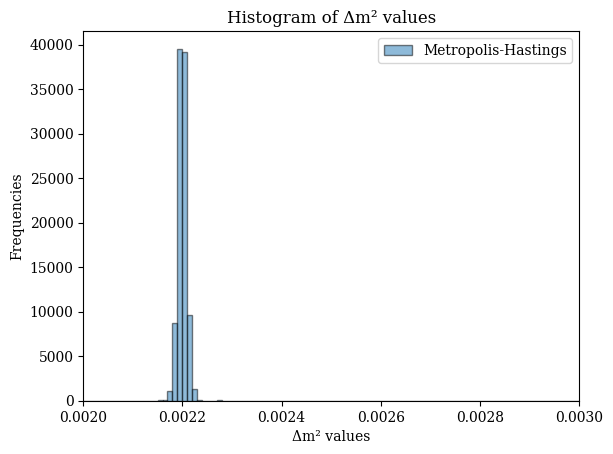

In [274]:
bins_dm2=np.arange(0,0.01,1e-5)

plt.hist(chain31_Dm2, bins=bins_dm2, alpha=0.5, label='Metropolis-Hastings', edgecolor='black', density=True)

# Ajouter des titres et des étiquettes
plt.title('Histogram of Δm² values')
plt.xlabel('Δm² values')
plt.ylabel('Frequencies')
plt.legend()

plt.xlim([0.002, 0.003])
plt.show()

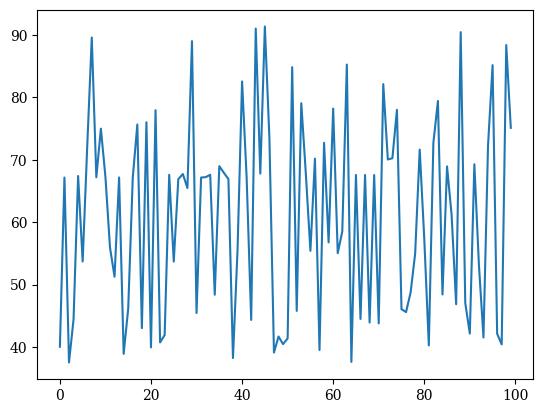

In [210]:
plt.plot(LIK[:100])

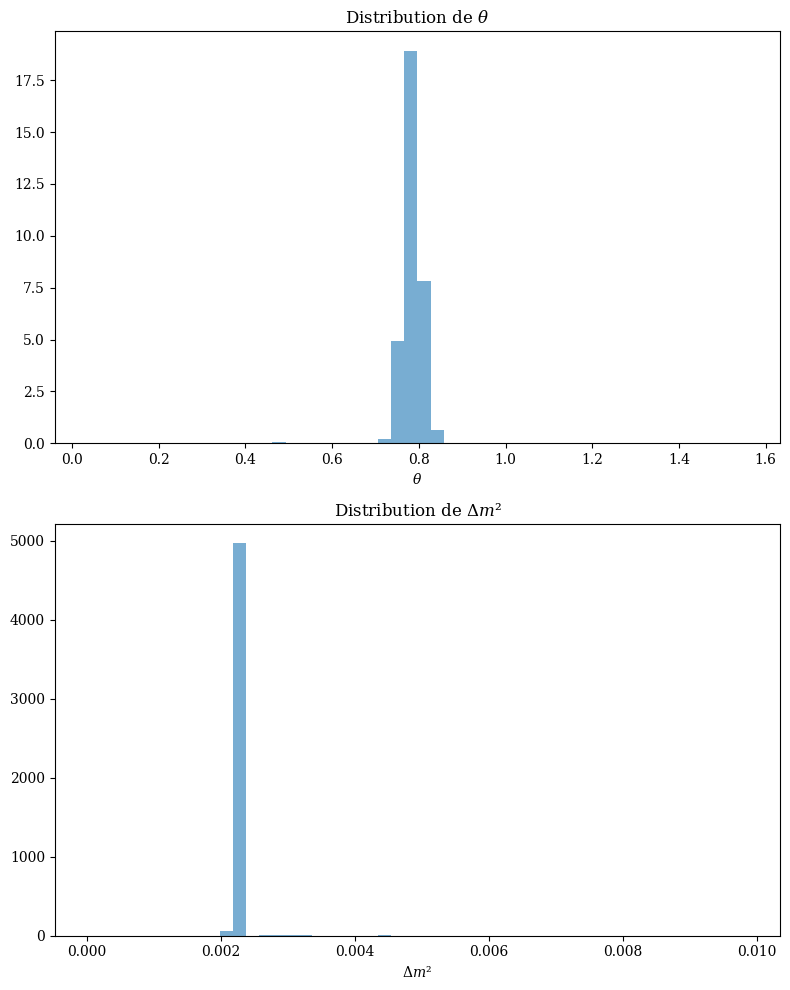

In [267]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 1, figsize=(8, 10))

# Tracer la distribution de theta
ax = axes[0]
ax.hist(theta_samples, bins=50, density=True, alpha=0.6)
ax.set_title(r'Distribution de $\theta$')
ax.set_xlabel(r'$\theta$')

# Tracer la distribution de Dm2  
ax = axes[1]  
ax.hist(Dm2_samples, bins=50, density=True, alpha=0.6)
ax.set_title(r'Distribution de $Δm²$')
ax.set_xlabel(r'$Δm²$')

plt.tight_layout()
plt.show()

In [190]:
len(theta_samples)

480000

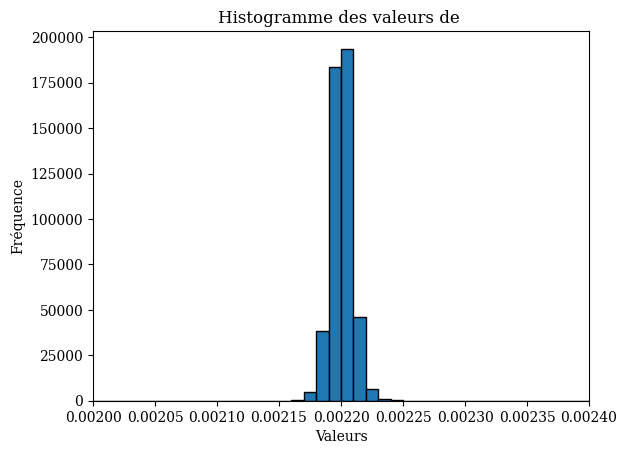

In [268]:
# Écrire les premières valeurs dans un fichier
with open('Emcee_values_Dm2.txt', 'w') as fichier:
    for array in Dm2_samples:
        fichier.write(f"{array}\n")

# Lire les valeurs depuis le fichier
valeurs = []
with open('Emcee_values_Dm2.txt', 'r') as fichier:
    lignes = fichier.readlines()
    for ligne in lignes:
        valeurs.append(float(ligne.strip()))

# Tracer l'histogramme
plt.hist(valeurs, bins=bins_dm2, edgecolor='black')
plt.title('Histogramme des valeurs de ')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.xlim([0.002, 0.0024])
plt.show()

In [220]:
bins_dm2=np.arange(0,0.01,1e-5)
bins_theta=np.arange(0,np.pi/2,1e-2)

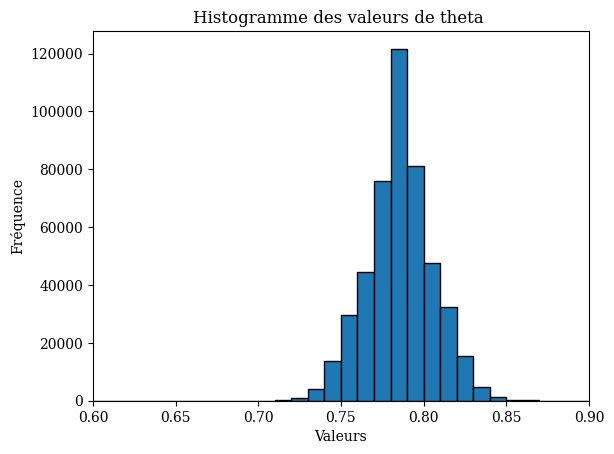

In [269]:
# Écrire les premières valeurs dans un fichier
with open('Emcee_values_theta.txt', 'w') as fichier:
    for array in theta_samples:
        fichier.write(f"{array}\n")

# Lire les valeurs depuis le fichier
valeurs = []
with open('Emcee_values_theta.txt', 'r') as fichier:
    lignes = fichier.readlines()
    for ligne in lignes:
        valeurs.append(float(ligne.strip()))

# Tracer l'histogramme
plt.hist(valeurs, bins=bins_theta, edgecolor='black')
plt.title('Histogramme des valeurs de theta ')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.xlim([0.6, 0.9])
plt.show()

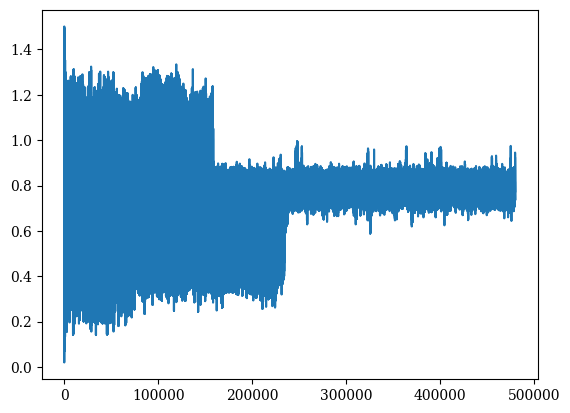

In [170]:
plt.plot(theta_samples)

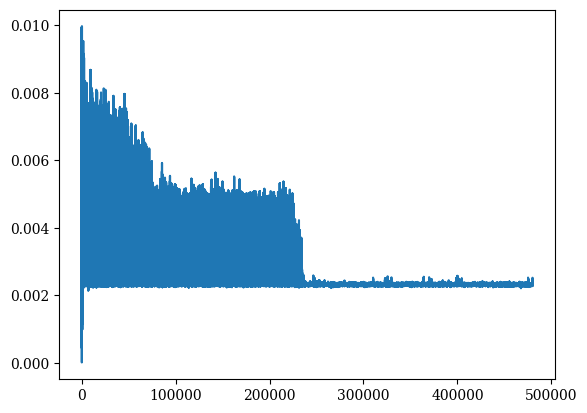

In [171]:
plt.plot(Dm2_samples)

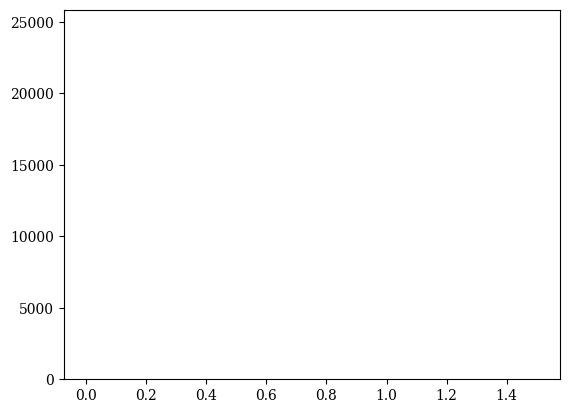

In [172]:
Dm2 = plt.hist(Dm2_samples, bins=5000, density=True, alpha=0.6)
Theta = plt.hist(theta_samples, bins=5000, density=True, alpha=0.6)

In [174]:
print(f"Le nombre de coup max pour la valeur de Δm² est {np.max(Dm2[0])}")
print(f"Le nombre de coup max pour la valeur de θ est {np.max(Theta[0])}")


for i in range(len(Dm2[0])):
   if Dm2[0][i] == np.max(Dm2[0]) :
        print(i)

for i in range(len(Theta[0])):
   if Theta[0][i] == np.max(Theta[0]) :
        print(i)
print('Elle vaut Δm² = ' + str(Dm2[1][1157]))
print('Elle vaut θ = ' + str(Theta[1][2581]))

Le nombre de coup max pour la valeur de Δm² est 24614.18392517034
Le nombre de coup max pour la valeur de θ est 13.576886118818008
1157
2581
Elle vaut Δm² = 0.002318359231406712
Elle vaut θ = 0.7845586374843373


In [ ]:
Dm2_samples

In [ ]:
### Prior on theta


In [ ]:
### Prior on Dm2


**2.1.2 Likelihood function**

As we compare histogram, we use $\mathcal{L}_i = exp(\ln(\mathcal{L}_i)) $ where $\ln(\mathcal{L}_i)$ is the log-likelihood ratio: 
$$-\ln(\mathcal{L}_i) = \sum_{j=1}^{N \ bins} N^H_{i,j}(\theta_i, \Delta m^2_i) -  N^D_{i,j} + N^D_{i,j} \ ln \left( \frac{N^D_{i,j}}{N^H_{i,j}(\theta_i, \Delta m^2_i)} \right) $$

with $N^D_{i,j}$ the number of event in each bin $j$ of the true histogram, and $N^H_{i,j}(\theta_i, \Delta m^2_i)$ the number of event in each bin $j$  of the computed histogram at this step $i$ 

In [ ]:
### Compute the likelihood


**2.1.3 Posterior probability**

We compute the unnormed posterior probability (ignoring the normalisation factor $1/P(D)$ as it cancelled out in the Metropolis-Hastings ratio): 
$$P(\theta_i, \Delta m^2_i | D)_{un} = \mathcal{L}_i \  P(\theta_i, \Delta m^2_i) $$

In [ ]:
### Compute the posterior probability


### 2.2 Jump function

We throw a value of $\theta$ at the step $i$ with a multvariate normal jump function: 
$$J (\theta_ i, \Delta m^2_i | \theta_{i-1}, \Delta m^2_{i-1}) = \mathcal{N}(\{ \theta_{i-1},  \Delta m^2_{i-1} \} , \Sigma_{\theta, \Delta m^2})$$ 
where $\Sigma = diag(\sigma_{\theta}, \sigma_{\Delta m^2})$ is a matrix with diagonal values the step size for each sampled parameter, which value is chosen heuristically and strongly impacts the convergence speed of the chain.


In [ ]:
### Compute the posterior probability


### 2.3 Acceptance function

The acceptance function is: 
$$ A (\theta_{i}, \Delta m^2_i )=min\{1,r_{i} \} $$
where $r_{i}$ is the Metropolis-Hastings ratio.

**2.3.1 Metropolis-Hastings ratio** 

We compute the Metropolis-Hastings ratio $r_i$ between the posterior probability at this step and at the previous step: 
$$r_i =\frac{P(\theta_i, \Delta m^2_i | D)_{un} \ J(\theta_{i-1}, \Delta m^2_{i-1} | \theta_i, \Delta m^2_{i}) }{P(\theta_{i-1}, \Delta m^2_{i-1} | D)_{un} \ J(\theta_{i}, \Delta m^2_{i} | \theta_{i-1}, \Delta m^2_{i-1})} $$



In [ ]:
### Compute the Metropolis-Hastings ratio


**2.3.2 Acceptance function**

The acceptance function returns if the step is accepted or not according to the Metropolis-Hastings ratio $r_i$ and following the properties: 
- $r_i \geq 1 \ \rightarrow $ the step is accepted
- $r_i < 1 \ \rightarrow $: a random number is thrown and: 
    - the step is accepted if  $r_i \geq U(0,1)$ 
    - the step is rejected if $r_i < U(0,1)$



In [ ]:
### Compute the acceptance function 


### 2.4 Start the Markov Chain



**2.4.1 Intitialise the chain**

We throw the first step $\theta_0, \Delta m^2_0$ and compute the corresponding posterior probability $P(\theta_0, \Delta m^2_0| D)_{un}$.


In [ ]:
### Create container arrays for values


In [ ]:
### Throw the first step


**2.4.2 Run the Markov Chain**

We run the Markov Chain for $N=10^6$ steps.

In [ ]:
# Run the MCMC


In [ ]:
# Save the output in a csv file


## 3. Analyse the Markov Chain output



### 3.1 The trace

The trace is the value of the sampled parameters as a function of the step. We use it to remove the steps sampled before the chained has converged.

In [ ]:
### Plot the MCMC trace


In [ ]:
### Remove burn-in, i.e. samples before convergence

burnin = 1000

### 3.2 The sampled  distribution

The $\{ \theta_i, \Delta m^2_i \}$ samples are proportional to the posterior distribution $P(\theta,  \Delta m^2 | D)$. 
We will plot their distribution and take the mode as the most probable value.
If the histogram is not smooth enough, is can either been smoothed with an interpolation function or more steps can be added to the chain. 


In [ ]:
### Plot the parameters samples - 2D histogram


In [ ]:
### Get the mode of the posterior distribution


In [ ]:
### Compare the fluxes
